In [1]:
import numpy as np
import os
import sys
sys.path.append(os.path.abspath(r'D:\Guvi_Project\Personalized Learning Assistant\src'))
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from Model_Training import pickle_dump
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load AG News dataset
dataset = load_dataset("ag_news")# Hugging Face dataset
texts = [item['text'] for item in dataset['train']]
labels = [item['label'] for item in dataset['train']]

In [3]:
dataset.save_to_disk(r'D:\Guvi_Project\Personalized Learning Assistant\data\raw\Topic_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/120000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7600 [00:00<?, ? examples/s]

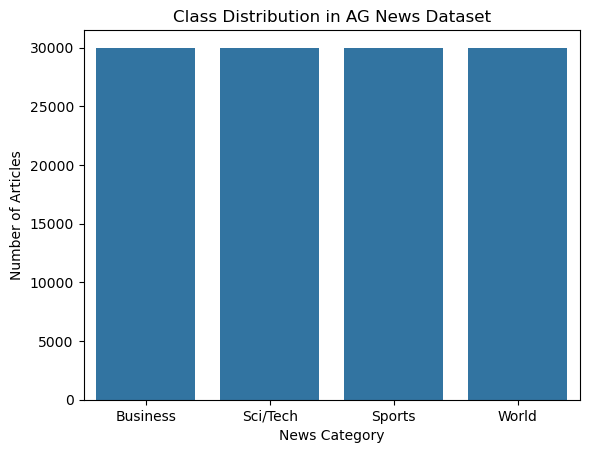

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame for easier analysis
df = pd.DataFrame({'text': texts, 'label': labels})
label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
df['label_name'] = df['label'].map(label_names)

# Plot class distribution
sns.countplot(x='label_name', data=df)
plt.title("Class Distribution in AG News Dataset")
plt.xlabel("News Category")
plt.ylabel("Number of Articles")
plt.show()


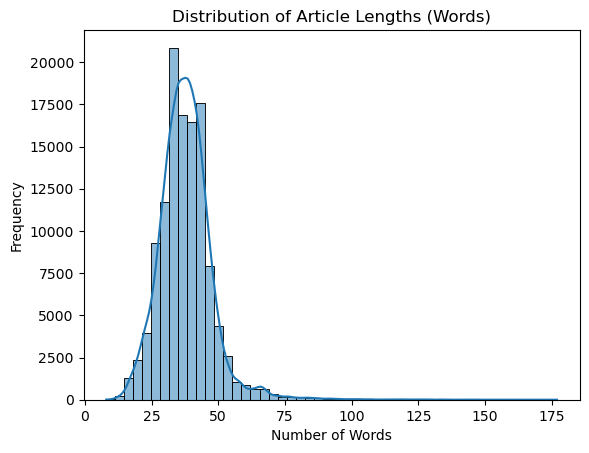

In [25]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Article Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [26]:
for i in range(4):
    print(f"\nCategory: {label_names[i]}")
    print(df[df['label'] == i]['text'].iloc[0])



Category: World
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

Category: Sports
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

Category: Business
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Category: Sci/Tech
'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little hi

In [6]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

pickle_dump(le, name ='LabelEncoder-sec5')

LabelEncoder-sec5 Model saved successfully.


In [7]:
# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100)
pickle_dump(tokenizer, name='Tokenizer-sec5')

Tokenizer-sec5 Model saved successfully.


In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_encoded, test_size=0.2)

In [9]:
# Download and load GloVe (100d)
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove_data

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
# Load GloVe embeddings
embedding_index = {}
glove_file_path = r"D:\Guvi_Project\Personalized Learning Assistant\data\raw\glove.6B.100d.txt"
with open(glove_file_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [11]:
# Create embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((10000, embedding_dim))
for word, i in word_index.items():
    if i < 10000 and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [12]:
# Build model with GloVe embedding
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=100, trainable=False))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # AG News has 4 labels --> 0: World, 1: Sports, 2: Business, 3: Sci/Tech.

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Train model
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 99ms/step - accuracy: 0.7965 - loss: 0.5484 - val_accuracy: 0.8951 - val_loss: 0.3032
Epoch 2/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 98ms/step - accuracy: 0.8956 - loss: 0.3146 - val_accuracy: 0.8994 - val_loss: 0.2913
Epoch 3/3
750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 99ms/step - accuracy: 0.9024 - loss: 0.2860 - val_accuracy: 0.9011 - val_loss: 0.2769


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 100, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (128, 64)              │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 64)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 32)              │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 4)               │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,133,358 (4.32 MB)

 Trainable params: 44,452 (173.64 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 88,906 (347.29 KB)

750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step
              precision    recall  f1-score   support

       World       0.94      0.87      0.90      6016
      Sports       0.96      0.98      0.97      5937
    Business       0.92      0.80      0.86      5997
    Sci/Tech       0.81      0.95      0.87      6050

    accuracy                           0.90     24000
   macro avg       0.91      0.90      0.90     24000
weighted avg       0.91      0.90      0.90     24000



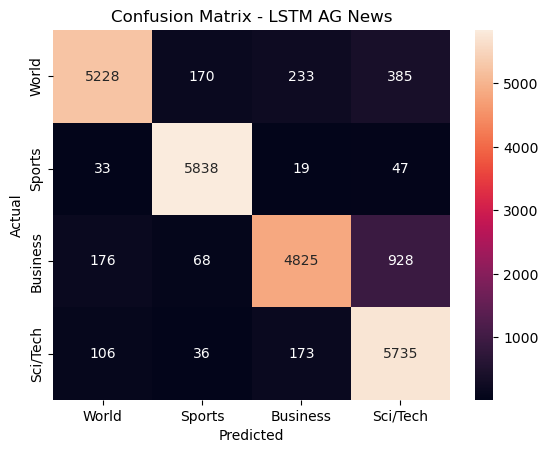

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print(classification_report(y_test, y_pred, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'],
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM AG News')
plt.show()


In [22]:
model.save(r'D:\Guvi_Project\Personalized Learning Assistant\models\llm_models\ag_news_lstm_model.h5')

In [23]:
# Predict on new sample
sample_text = ["Apple released a new iPhone with advanced camera features"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_pad = pad_sequences(sample_seq, maxlen=100)
pred = model.predict(sample_pad)
predicted_label = le.inverse_transform([np.argmax(pred)])

print("Predicted topic:", predicted_label[0])
# AG News has 4 labels --> 0: World, 1: Sports, 2: Business, 3: Sci/Tech.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Predicted topic: 3
